In [9]:
from IPython import get_ipython
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score, recall_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # This is the crucial import

In [10]:
# Load data
df = pd.read_csv("adult.csv")

# Replace "?" with NaN for all columns
df.replace("?", np.nan, inplace=True)

# Impute missing values for numeric columns with median
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)

# Impute missing values for categorical columns with mode
for col in df.select_dtypes(include=['object', 'category']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)


In [11]:
df.columns = df.columns.str.replace('.', '_', regex=False)
df.columns = df.columns.str.replace('-', '_', regex=False)


In [17]:
def feature_engineering(df):
    # Map country to region
    def map_country(country):
        if country == 'United-States':
            return 'US'
        elif country in ['England', 'Germany', 'Italy', 'France']:
            return 'Europe'
        elif country in ['India', 'China', 'Philippines', 'Vietnam']:
            return 'Asia'
        else:
            return 'Other'

    df = df.copy()  # to avoid SettingWithCopyWarning

    # Age binning
    df['age_bin'] = pd.cut(df['age'], bins=[0, 30, 45, 60, 100], labels=['Young', 'Middle-aged', 'Senior', 'Elder'])

    # Interaction feature
    df['edu_marital'] = df['education'] + "_" + df['marital_status']

    # Region from native_country
    df['region'] = df['native_country'].apply(map_country)

    # Rename columns to use underscores
    df.columns = df.columns.str.replace('.', '_', regex=False)
    df.columns = df.columns.str.replace('-', '_', regex=False)

    return df

# Apply feature engineering and renaming to each subset
X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)
X_test = feature_engineering(X_test)

In [18]:
print(df.columns)


Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income', 'age_bin', 'edu_marital', 'region'],
      dtype='object')


In [14]:
df = feature_engineering(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       32561 non-null  object  
 2   fnlwgt          32561 non-null  int64   
 3   education       32561 non-null  object  
 4   education_num   32561 non-null  int64   
 5   marital_status  32561 non-null  object  
 6   occupation      32561 non-null  object  
 7   relationship    32561 non-null  object  
 8   race            32561 non-null  object  
 9   sex             32561 non-null  object  
 10  capital_gain    32561 non-null  int64   
 11  capital_loss    32561 non-null  int64   
 12  hours_per_week  32561 non-null  int64   
 13  native_country  32561 non-null  object  
 14  income          32561 non-null  object  
 15  age_bin         32561 non-null  category
 16  edu_marital     32561 non-null  object  
 17  region      

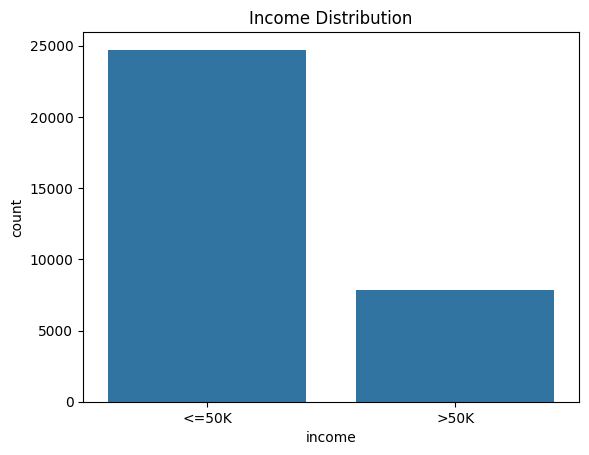

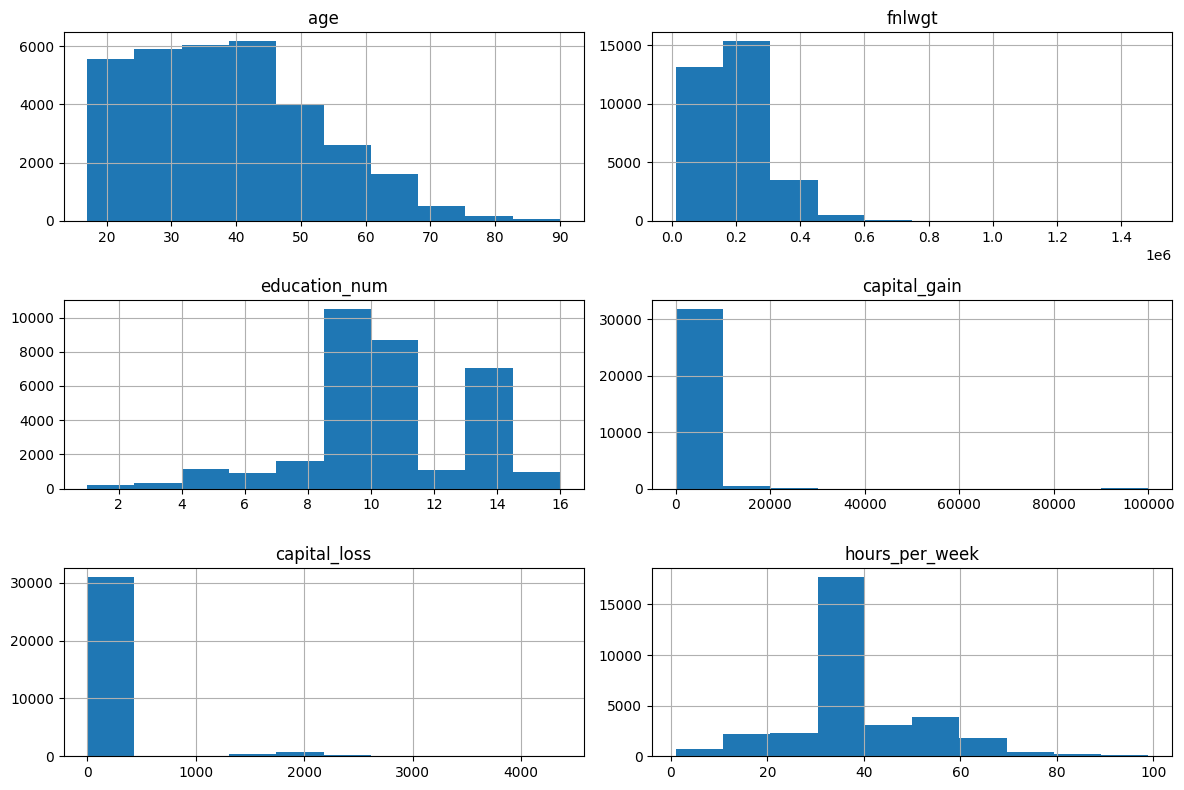

In [15]:
# EDA: Basic info and statistics
print(df.info())
print(df.describe())
print(df['income'].value_counts())

# EDA: Visualize class balance
sns.countplot(x='income', data=df)
plt.title('Income Distribution')
plt.show()

# EDA: Visualize numeric feature distributions (optional)
df.select_dtypes(include=np.number).hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [88]:
print(df.columns.tolist())


['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']


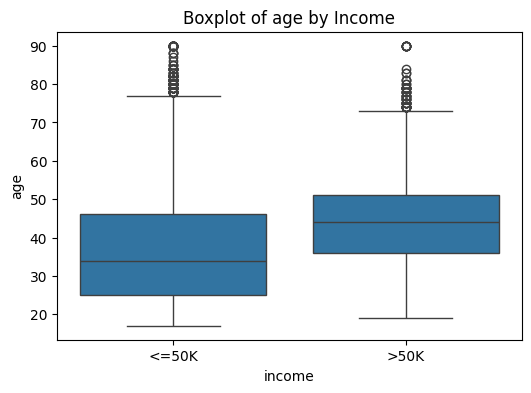

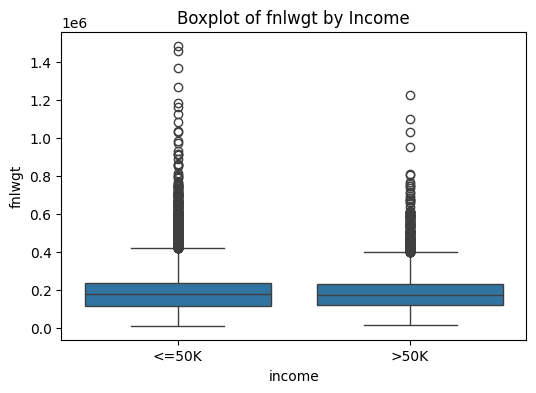

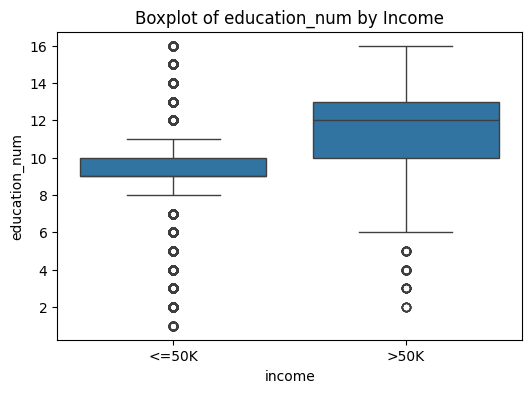

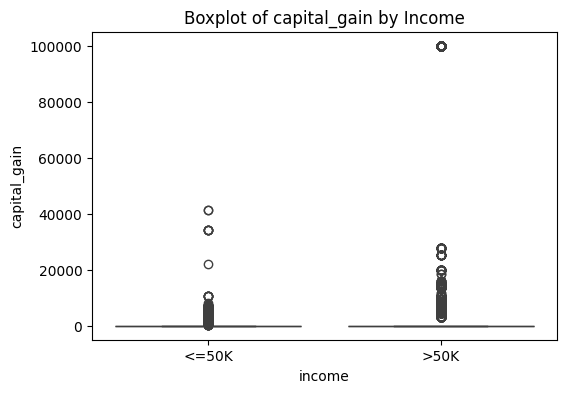

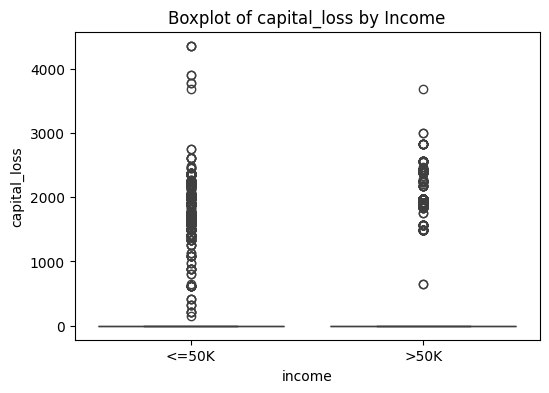

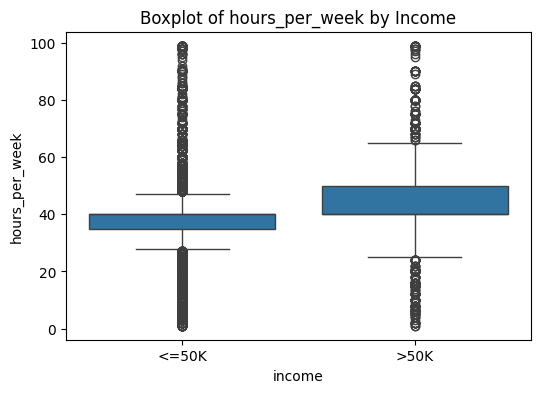

In [89]:
for col in df.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='income', y=col, data=df)
    plt.title(f'Boxplot of {col} by Income')
    plt.show()

In [90]:
X = df.drop(columns='income')
y = df['income']


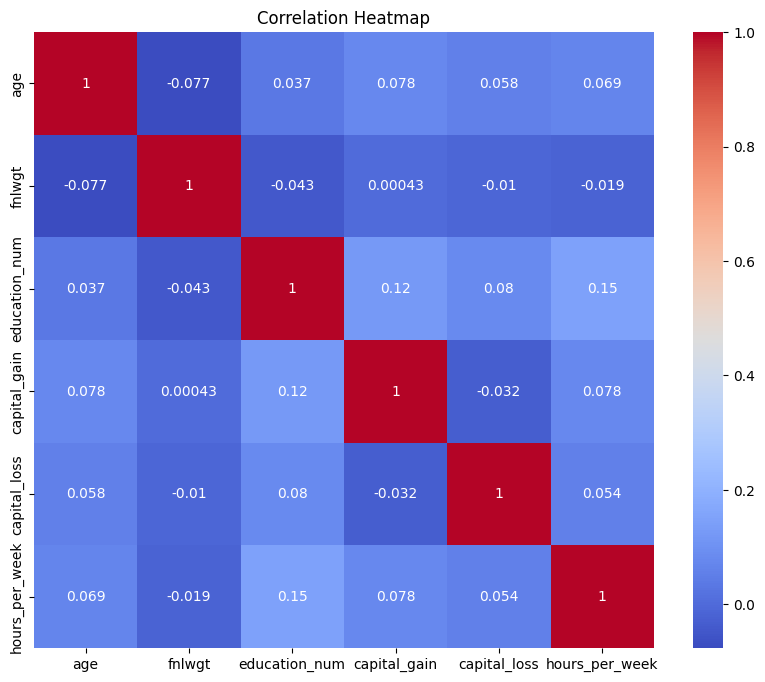

In [91]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [22]:
target = 'income'
X = df.drop(columns=target)
y = df[target]
y_bin = (y == '>50K').astype(int)

# Train/val/test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42
)
X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)
X_test = feature_engineering(X_test)

y_bin_train = (y_train == '>50K').astype(int)
y_bin_val = (y_val == '>50K').astype(int)
y_bin_test = (y_test == '>50K').astype(int)

# Feature lists for pipeline
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [23]:
def feature_engineering(df):
    # Map country to region
    def map_country(country):
        if country == 'United-States':
            return 'US'
        elif country in ['England', 'Germany', 'Italy', 'France']:
            return 'Europe'
        elif country in ['India', 'China', 'Philippines', 'Vietnam']:
            return 'Asia'
        else:
            return 'Other'

    df = df.copy()  # to avoid SettingWithCopyWarning

    # Age binning
    df['age_bin'] = pd.cut(df['age'], bins=[0, 30, 45, 60, 100], labels=['Young', 'Middle-aged', 'Senior', 'Elder'])

    # Interaction feature
    df['edu_marital'] = df['education'] + "_" + df['marital_status']

    # Region from native_country
    df['region'] = df['native_country'].apply(map_country)

    # Rename columns to use underscores
    df.columns = df.columns.str.replace('.', '_', regex=False)
    df.columns = df.columns.str.replace('-', '_', regex=False)

    return df

# Apply feature engineering and renaming to each subset
X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)
X_test = feature_engineering(X_test)

In [26]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

smote = SMOTE(random_state=42)

In [27]:
pipe_rf = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [15, 25],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training Random Forest (optimizing recall)...")
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring='recall', cv=cv, n_jobs=-1, verbose=2)
grid_rf.fit(X_train, y_bin_train)

y_train_pred_rf = grid_rf.predict(X_train)
y_pred_rf = grid_rf.predict(X_test)
print("Random Forest Training Accuracy:", accuracy_score(y_bin_train, y_train_pred_rf))
print("Random Forest Test Accuracy:", accuracy_score(y_bin_test, y_pred_rf))
print("=== Random Forest (All Features) ===")
print(classification_report(y_bin_test, y_pred_rf))
print("Accuracy (Random Forest):", accuracy_score(y_bin_test, y_pred_rf))

Training Random Forest (optimizing recall)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Random Forest Training Accuracy: 0.8377866502866503
Random Forest Test Accuracy: 0.8109933978197451
=== Random Forest (All Features) ===
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      4945
           1       0.58      0.82      0.68      1568

    accuracy                           0.81      6513
   macro avg       0.75      0.81      0.77      6513
weighted avg       0.85      0.81      0.82      6513

Accuracy (Random Forest): 0.8109933978197451


In [62]:
# pipe_lr = ImbPipeline([
#     ('preprocessor', preprocessor),
#     # ('smote', smote),  # Remove SMOTE for LR
#     ('clf', LogisticRegression(max_iter=1000, random_state=42))
# ])

# param_grid_lr = {
#     'clf__C': [1e-6, 1e-5, 1e-4],  # much smaller than before
#     'clf__penalty': ['l2'],
#     'clf__class_weight': [None]
# }
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# print("Training Logistic Regression (all features)...")
# grid_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring='recall', cv=cv, n_jobs=-1, verbose=2)
# grid_lr.fit(X_train, y_bin_train)


pipe_lr = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('clf', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

param_grid_lr = {
    'clf__C': [1e-4, 1e-3, 1e-2],
    'clf__penalty': ['l2'],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training Logistic Regression (with SMOTE and class_weight='balanced')...")
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring='recall', cv=cv, n_jobs=-1, verbose=2)
grid_lr.fit(X_train, y_bin_train)

y_train_pred_lr = grid_lr.predict(X_train)
y_pred_lr = grid_lr.predict(X_test)
print("Logistic Regression Training Accuracy:", accuracy_score(y_bin_train, y_train_pred_lr))
print("Logistic Regression Test Accuracy:", accuracy_score(y_bin_test, y_pred_lr))
print("=== Logistic Regression (All Features) ===")
print(classification_report(y_bin_test, y_pred_lr))
print("Accuracy (Logistic Regression):", accuracy_score(y_bin_test, y_pred_lr))

Training Logistic Regression (with SMOTE and class_weight='balanced')...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Logistic Regression Training Accuracy: 0.8108108108108109
Logistic Regression Test Accuracy: 0.805926608321818
=== Logistic Regression (All Features) ===
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      4945
           1       0.56      0.85      0.68      1568

    accuracy                           0.81      6513
   macro avg       0.75      0.82      0.77      6513
weighted avg       0.85      0.81      0.82      6513

Accuracy (Logistic Regression): 0.805926608321818


In [30]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np

# --- RANDOM FOREST ---

# 1. Tune threshold on validation set
y_probs_val_rf = grid_rf.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.3, 0.71, 0.01)
best_f1_rf = 0
best_thresh_rf = 0.5

for thresh in thresholds:
    y_pred_val = (y_probs_val_rf >= thresh).astype(int)
    f1 = f1_score(y_bin_val, y_pred_val)
    if f1 > best_f1_rf:
        best_f1_rf = f1
        best_thresh_rf = thresh

print(f"Random Forest - Best threshold for F1 (validation): {best_thresh_rf:.2f} (F1: {best_f1_rf:.4f})")

# 2. Apply best threshold to test set
y_probs_test_rf = grid_rf.predict_proba(X_test)[:, 1]
y_pred_test_rf = (y_probs_test_rf >= best_thresh_rf).astype(int)
print("Random Forest Training Accuracy:", accuracy_score(y_bin_train, y_train_pred_rf))
print("Random Forest Test Accuracy:", accuracy_score(y_bin_test, y_pred_rf))

print("\nRandom Forest - Test set metrics at best validation threshold:")
print(classification_report(y_bin_test, y_pred_test_rf))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_test_rf))


# --- LOGISTIC REGRESSION ---

# 1. Tune threshold on validation set
y_probs_val_lr = grid_lr.predict_proba(X_val)[:, 1]
best_f1_lr = 0
best_thresh_lr = 0.5

for thresh in thresholds:
    y_pred_val = (y_probs_val_lr >= thresh).astype(int)
    f1 = f1_score(y_bin_val, y_pred_val)
    if f1 > best_f1_lr:
        best_f1_lr = f1
        best_thresh_lr = thresh

print(f"\nLogistic Regression - Best threshold for F1 (validation): {best_thresh_lr:.2f} (F1: {best_f1_lr:.4f})")

# 2. Apply best threshold to test set
y_probs_test_lr = grid_lr.predict_proba(X_test)[:, 1]
y_pred_test_lr = (y_probs_test_lr >= best_thresh_lr).astype(int)


print("Logistic Regression Training Accuracy:", accuracy_score(y_bin_train, y_train_pred_lr))
print("Logistic Regression Test Accuracy:", accuracy_score(y_bin_test, y_pred_lr))
print("\nLogistic Regression - Test set metrics at best validation threshold:")
print(classification_report(y_bin_test, y_pred_test_lr))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_test_lr))

Random Forest - Best threshold for F1 (validation): 0.57 (F1: 0.6888)
Random Forest Training Accuracy: 0.8377866502866503
Random Forest Test Accuracy: 0.8109933978197451

Random Forest - Test set metrics at best validation threshold:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      4945
           1       0.61      0.75      0.67      1568

    accuracy                           0.82      6513
   macro avg       0.76      0.80      0.78      6513
weighted avg       0.84      0.82      0.83      6513

Confusion Matrix:
 [[4189  756]
 [ 385 1183]]

Logistic Regression - Best threshold for F1 (validation): 0.62 (F1: 0.6929)
Logistic Regression Training Accuracy: 0.8108108108108109
Logistic Regression Test Accuracy: 0.805926608321818

Logistic Regression - Test set metrics at best validation threshold:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      4945
           1       0.63   

In [31]:
from sklearn.metrics import f1_score, precision_score, classification_report, confusion_matrix
import numpy as np

# Get predicted probabilities for class 1
y_probs_lr = grid_lr.predict_proba(X_test)[:, 1]

# Best F1 threshold
thresholds = np.arange(0.3, 0.71, 0.01)
best_f1 = 0
best_thresh_f1 = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_probs_lr >= thresh).astype(int)
    f1 = f1_score(y_bin_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh_f1 = thresh

print(f"\nBest threshold for F1-score (Logistic Regression): {best_thresh_f1:.2f} (F1: {best_f1:.4f})")
y_pred_lr_best_f1 = (y_probs_lr >= best_thresh_f1).astype(int)
print(classification_report(y_bin_test, y_pred_lr_best_f1))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_lr_best_f1))

# Best Precision threshold
best_precision = 0
best_thresh_prec = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_probs_lr >= thresh).astype(int)
    precision = precision_score(y_bin_test, y_pred_thresh)
    if precision > best_precision:
        best_precision = precision
        best_thresh_prec = thresh

print(f"\nBest threshold for Precision (Logistic Regression): {best_thresh_prec:.2f} (Precision: {best_precision:.4f})")
y_pred_lr_best_prec = (y_probs_lr >= best_thresh_prec).astype(int)
print(classification_report(y_bin_test, y_pred_lr_best_prec))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_lr_best_prec))


Best threshold for F1-score (Logistic Regression): 0.64 (F1: 0.6894)
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4945
           1       0.65      0.73      0.69      1568

    accuracy                           0.84      6513
   macro avg       0.78      0.80      0.79      6513
weighted avg       0.85      0.84      0.84      6513

Confusion Matrix:
 [[4338  607]
 [ 424 1144]]

Best threshold for Precision (Logistic Regression): 0.70 (Precision: 0.6974)
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4945
           1       0.70      0.66      0.68      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.78      0.79      6513
weighted avg       0.85      0.85      0.85      6513

Confusion Matrix:
 [[4499  446]
 [ 540 1028]]


In [32]:
# Get predicted probabilities for class 1
y_probs_rf = grid_rf.predict_proba(X_test)[:, 1]

# Best F1 threshold
best_f1 = 0
best_thresh_f1 = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_probs_rf >= thresh).astype(int)
    f1 = f1_score(y_bin_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh_f1 = thresh

print(f"\nBest threshold for F1-score (Random Forest): {best_thresh_f1:.2f} (F1: {best_f1:.4f})")
y_pred_rf_best_f1 = (y_probs_rf >= best_thresh_f1).astype(int)
print(classification_report(y_bin_test, y_pred_rf_best_f1))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_rf_best_f1))

# Best Precision threshold
best_precision = 0
best_thresh_prec = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_probs_rf >= thresh).astype(int)
    precision = precision_score(y_bin_test, y_pred_thresh)
    if precision > best_precision:
        best_precision = precision
        best_thresh_prec = thresh

print(f"\nBest threshold for Precision (Random Forest): {best_thresh_prec:.2f} (Precision: {best_precision:.4f})")
y_pred_rf_best_prec = (y_probs_rf >= best_thresh_prec).astype(int)
print(classification_report(y_bin_test, y_pred_rf_best_prec))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_rf_best_prec))


Best threshold for F1-score (Random Forest): 0.61 (F1: 0.6784)
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4945
           1       0.65      0.71      0.68      1568

    accuracy                           0.84      6513
   macro avg       0.78      0.79      0.78      6513
weighted avg       0.84      0.84      0.84      6513

Confusion Matrix:
 [[4335  610]
 [ 450 1118]]

Best threshold for Precision (Random Forest): 0.70 (Precision: 0.7331)
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4945
           1       0.73      0.57      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.75      0.77      6513
weighted avg       0.84      0.85      0.84      6513

Confusion Matrix:
 [[4618  327]
 [ 670  898]]


In [33]:
# Threshold tuning for Random Forest
y_probs_rf = grid_rf.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.3, 0.71, 0.01)
best_recall = 0
best_thresh = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_probs_rf >= thresh).astype(int)
    recall = recall_score(y_bin_test, y_pred_thresh)
    if recall > best_recall:
        best_recall = recall
        best_thresh = thresh

print(f"\nBest threshold for recall: {best_thresh:.2f} (Recall: {best_recall:.4f})")
y_pred_rf_best = (y_probs_rf >= best_thresh).astype(int)
print(classification_report(y_bin_test, y_pred_rf_best))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_rf_best))


Best threshold for recall: 0.30 (Recall: 0.9279)
              precision    recall  f1-score   support

           0       0.97      0.69      0.80      4945
           1       0.49      0.93      0.64      1568

    accuracy                           0.75      6513
   macro avg       0.73      0.81      0.72      6513
weighted avg       0.85      0.75      0.76      6513

Confusion Matrix:
 [[3402 1543]
 [ 113 1455]]


In [34]:
# Threshold tuning for Logistic Regression
y_probs_lr = grid_lr.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.3, 0.71, 0.01)
best_recall = 0
best_thresh = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_probs_lr >= thresh).astype(int)
    recall = recall_score(y_bin_test, y_pred_thresh)
    if recall > best_recall:
        best_recall = recall
        best_thresh = thresh

print(f"\nBest threshold for recall: {best_thresh:.2f} (Recall: {best_recall:.4f})")
y_pred_lr_best = (y_probs_lr >= best_thresh).astype(int)
print(classification_report(y_bin_test, y_pred_lr_best))
print("Confusion Matrix:\n", confusion_matrix(y_bin_test, y_pred_lr_best))


Best threshold for recall: 0.30 (Recall: 0.9330)
              precision    recall  f1-score   support

           0       0.97      0.67      0.80      4945
           1       0.48      0.93      0.63      1568

    accuracy                           0.74      6513
   macro avg       0.72      0.80      0.71      6513
weighted avg       0.85      0.74      0.76      6513

Confusion Matrix:
 [[3333 1612]
 [ 105 1463]]


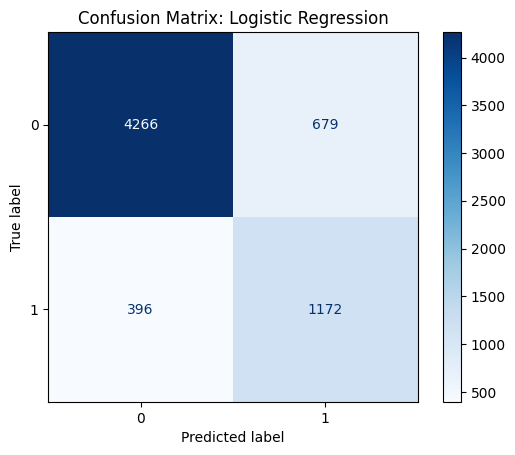

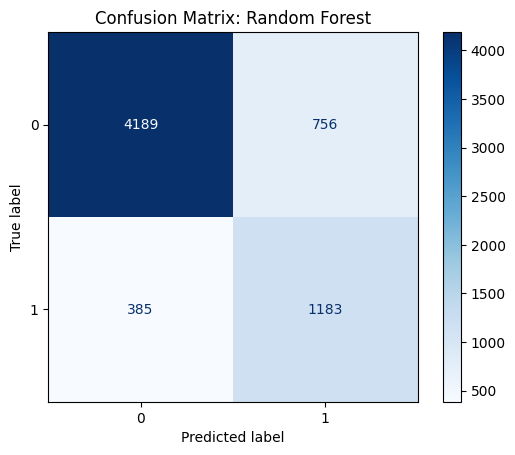

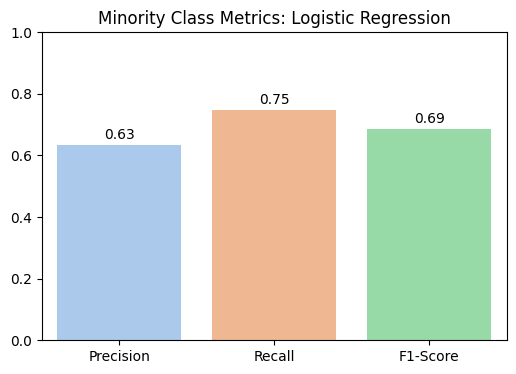

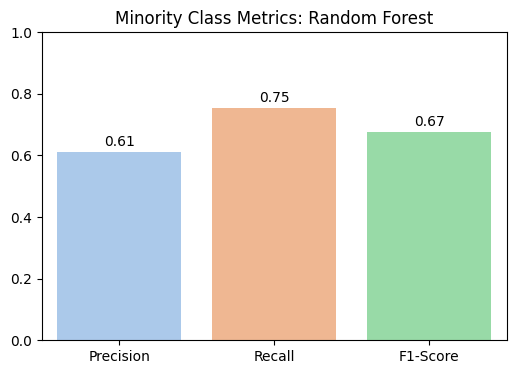

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Function to plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

# Plot confusion matrices
plot_conf_matrix(y_bin_test, y_pred_test_lr, 'Logistic Regression')
plot_conf_matrix(y_bin_test, y_pred_test_rf, 'Random Forest')

# Plot bar chart of precision, recall, F1 for minority class (label = 1)
def plot_minority_metrics(y_true, y_pred, title):
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)

    metrics = [precision, recall, f1]
    labels = ['Precision', 'Recall', 'F1-Score']

    plt.figure(figsize=(6, 4))
    sns.barplot(x=labels, y=metrics, palette='pastel')
    plt.ylim(0, 1)
    plt.title(f'Minority Class Metrics: {title}')
    for i, v in enumerate(metrics):
        plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
    plt.show()

# Plot metrics for both models
plot_minority_metrics(y_bin_test, y_pred_test_lr, 'Logistic Regression')
plot_minority_metrics(y_bin_test, y_pred_test_rf, 'Random Forest')


Random Forest Minority Class Metrics - Train: (0.8278427205100957, 0.6601694915254237, 0.7345591702027345)
Random Forest Minority Class Metrics - Test: (0.7544642857142857, 0.6101083032490975, 0.6746506986027944)


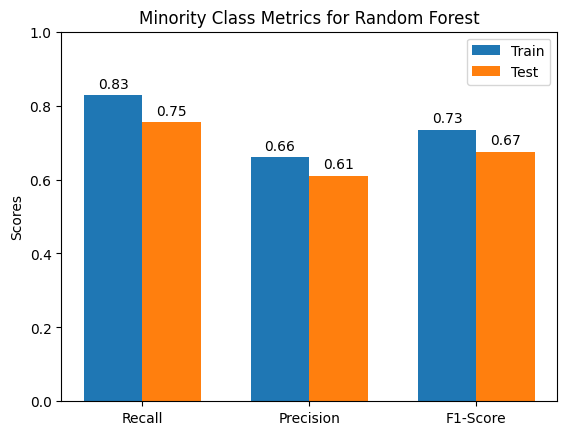

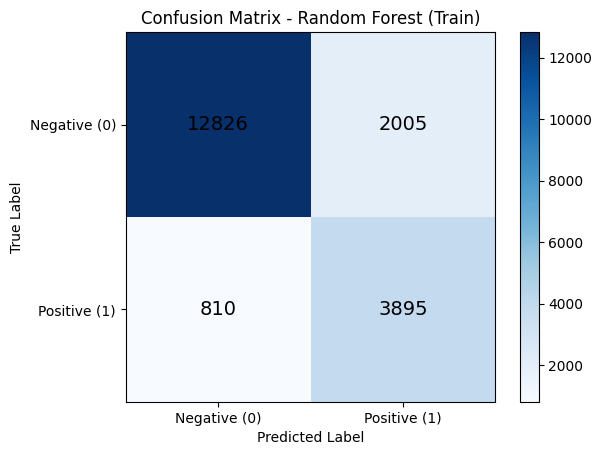

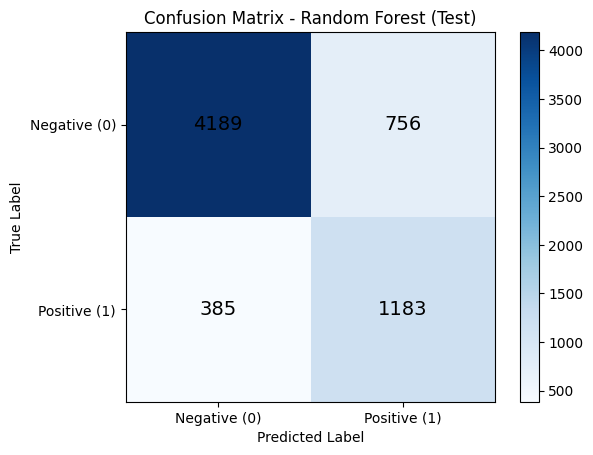

Logistic Regression Minority Class Metrics - Train: (0.7557917109458023, 0.643387009227429, 0.6950742767787333)
Logistic Regression Minority Class Metrics - Test: (0.7474489795918368, 0.6331712587790383, 0.6855805791167008)


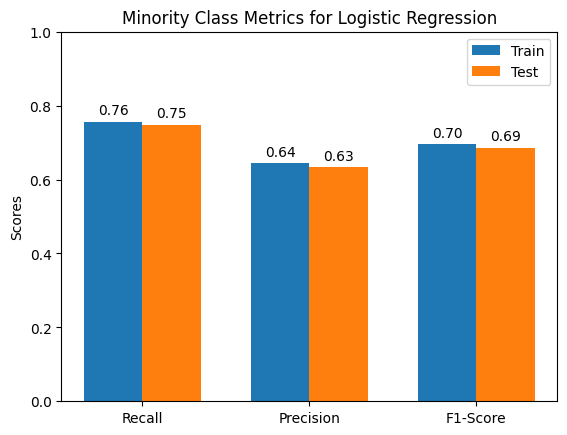

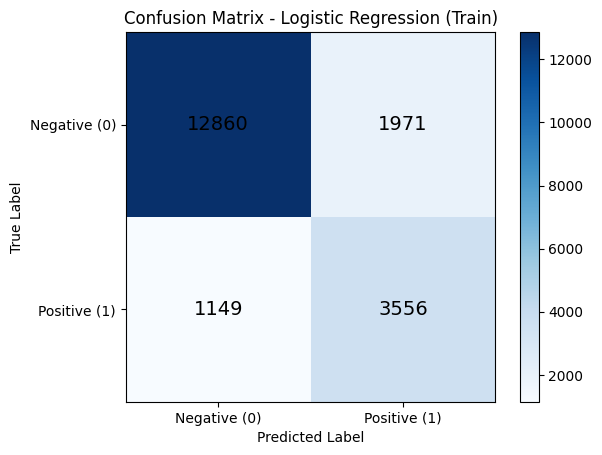

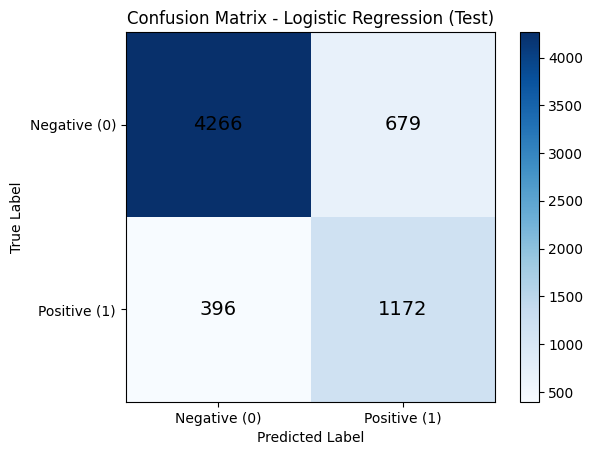

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score
import numpy as np

def minority_class_metrics(y_true, y_pred, minority_class=1):
    recall = recall_score(y_true, y_pred, pos_label=minority_class)
    precision = precision_score(y_true, y_pred, pos_label=minority_class)
    f1 = f1_score(y_true, y_pred, pos_label=minority_class)
    return recall, precision, f1

def plot_metrics(train_metrics, test_metrics, model_name):
    labels = ['Recall', 'Precision', 'F1-Score']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - width/2, train_metrics, width, label='Train')
    ax.bar(x + width/2, test_metrics, width, label='Test')

    ax.set_ylabel('Scores')
    ax.set_title(f'Minority Class Metrics for {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0,1)
    ax.legend()

    for i, v in enumerate(train_metrics):
        ax.text(i - width/2, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)
    for i, v in enumerate(test_metrics):
        ax.text(i + width/2, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

    plt.show()

def plot_conf_matrix(y_true, y_pred, model_name, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    ax.set_title(f'Confusion Matrix - {model_name} ({dataset_name})')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Negative (0)', 'Positive (1)'])
    ax.set_yticklabels(['Negative (0)', 'Positive (1)'])

    # Annotate the confusion matrix cells
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=14)

    plt.colorbar(im)
    plt.show()

# --- RANDOM FOREST ---

# Predict probabilities and apply threshold on train and test sets
y_probs_train_rf = grid_rf.predict_proba(X_train)[:, 1]
y_pred_train_rf = (y_probs_train_rf >= best_thresh_rf).astype(int)

y_probs_test_rf = grid_rf.predict_proba(X_test)[:, 1]
y_pred_test_rf = (y_probs_test_rf >= best_thresh_rf).astype(int)

# Calculate minority class metrics for train and test
train_metrics_rf = minority_class_metrics(y_bin_train, y_pred_train_rf)
test_metrics_rf = minority_class_metrics(y_bin_test, y_pred_test_rf)

print("Random Forest Minority Class Metrics - Train:", train_metrics_rf)
print("Random Forest Minority Class Metrics - Test:", test_metrics_rf)

# Plot bar chart comparison
plot_metrics(train_metrics_rf, test_metrics_rf, "Random Forest")

# Plot confusion matrices
plot_conf_matrix(y_bin_train, y_pred_train_rf, "Random Forest", "Train")
plot_conf_matrix(y_bin_test, y_pred_test_rf, "Random Forest", "Test")


# --- LOGISTIC REGRESSION ---

# Predict probabilities and apply threshold on train and test sets
y_probs_train_lr = grid_lr.predict_proba(X_train)[:, 1]
y_pred_train_lr = (y_probs_train_lr >= best_thresh_lr).astype(int)

y_probs_test_lr = grid_lr.predict_proba(X_test)[:, 1]
y_pred_test_lr = (y_probs_test_lr >= best_thresh_lr).astype(int)

# Calculate minority class metrics for train and test
train_metrics_lr = minority_class_metrics(y_bin_train, y_pred_train_lr)
test_metrics_lr = minority_class_metrics(y_bin_test, y_pred_test_lr)

print("Logistic Regression Minority Class Metrics - Train:", train_metrics_lr)
print("Logistic Regression Minority Class Metrics - Test:", test_metrics_lr)

# Plot bar chart comparison
plot_metrics(train_metrics_lr, test_metrics_lr, "Logistic Regression")

# Plot confusion matrices
plot_conf_matrix(y_bin_train, y_pred_train_lr, "Logistic Regression", "Train")
plot_conf_matrix(y_bin_test, y_pred_test_lr, "Logistic Regression", "Test")


In [37]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define your categorical features
categorical_features = ['workclass', 'education', 'marital_status', 'occupation',
                        'relationship', 'race', 'sex', 'native_country',
                        'age_bin', 'edu_marital', 'region']

# Create preprocessing step for encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)
#Build pipeline with classifier (encoding happens here)
model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [38]:
# --- Fit the model ---
model_pipeline.fit(X_train, y_train)

# --- Transform data to encoded DataFrame ---
X_transformed = model_pipeline.named_steps['preprocessing'].transform(X_train)

# Get column names
ohe = model_pipeline.named_steps['preprocessing'].named_transformers_['cat']
encoded_columns = ohe.get_feature_names_out(categorical_features)
passthrough_columns = [col for col in X_train.columns if col not in categorical_features]
all_feature_names = np.concatenate([encoded_columns, passthrough_columns])

# Convert to DataFrame
X_transformed_df = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, 'toarray') else X_transformed,
                                columns=all_feature_names)

# Show preview
print(X_transformed_df.head())



   workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                    0.0                  0.0                     0.0   
1                    0.0                  0.0                     0.0   
2                    0.0                  0.0                     0.0   
3                    0.0                  0.0                     0.0   
4                    0.0                  0.0                     0.0   

   workclass_Private  workclass_Self-emp-inc  workclass_Self-emp-not-inc  \
0                0.0                     0.0                         0.0   
1                1.0                     0.0                         0.0   
2                0.0                     0.0                         0.0   
3                1.0                     0.0                         0.0   
4                0.0                     0.0                         1.0   

   workclass_State-gov  workclass_Without-pay  education_10th  education_11th  \
0                  1.0 

In [39]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed_df, y_train)


# Print class distribution
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_resampled))


Before SMOTE: Counter({'<=50K': 14831, '>50K': 4705})
After SMOTE: Counter({'>50K': 14831, '<=50K': 14831})


In [40]:
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

def plot_roc_pr_curves(model, X_test, y_test, model_name="Model"):
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = roc_auc_score(y_test, probs)
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap_score = average_precision_score(y_test, probs)

    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'AP = {ap_score:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.legend()
    plt.show()

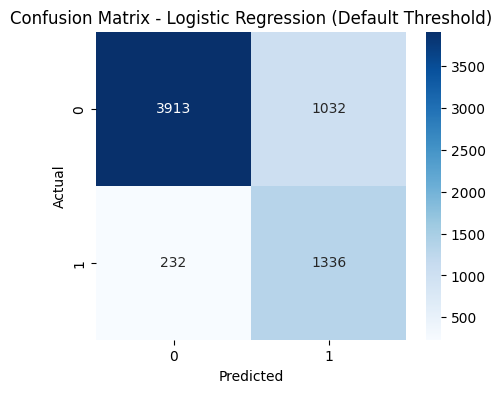

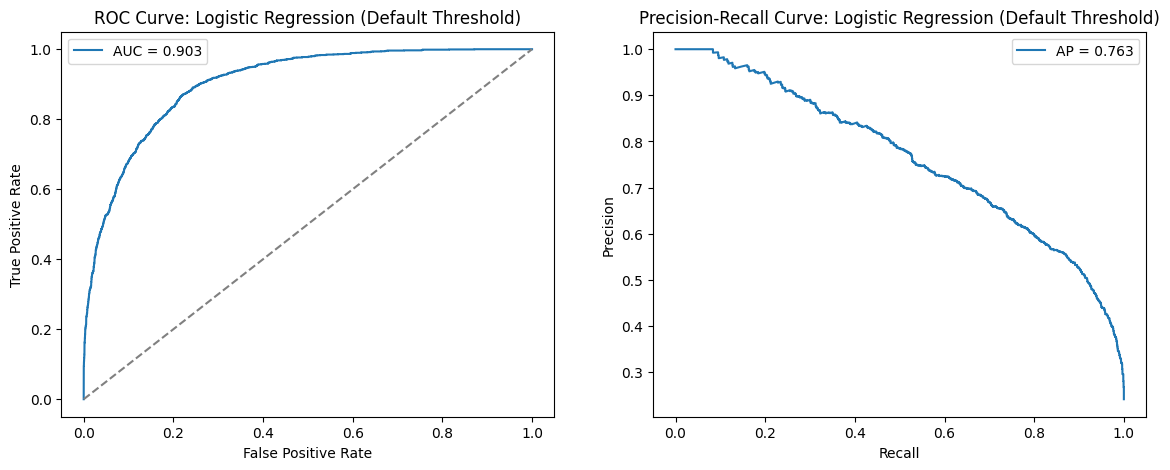

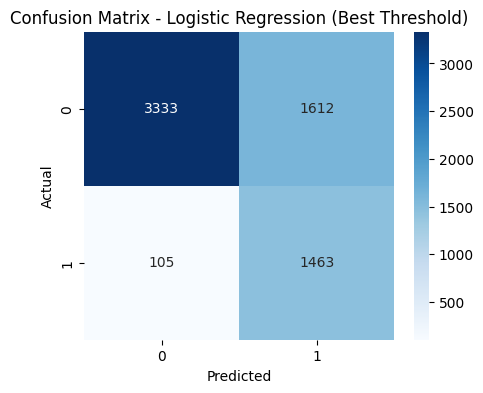

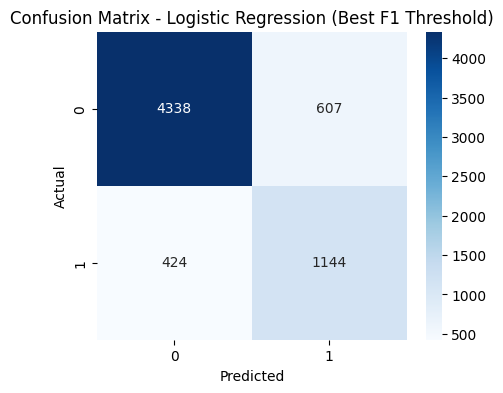

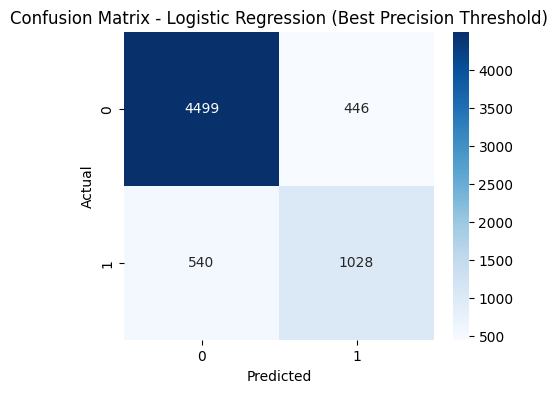

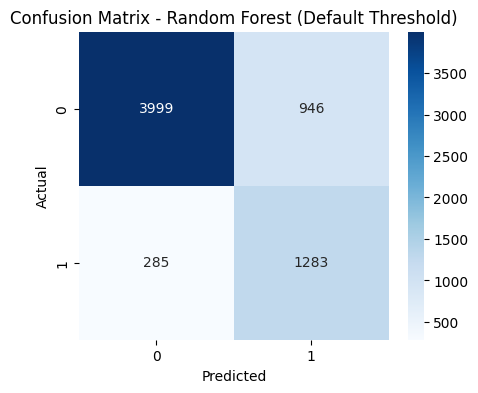

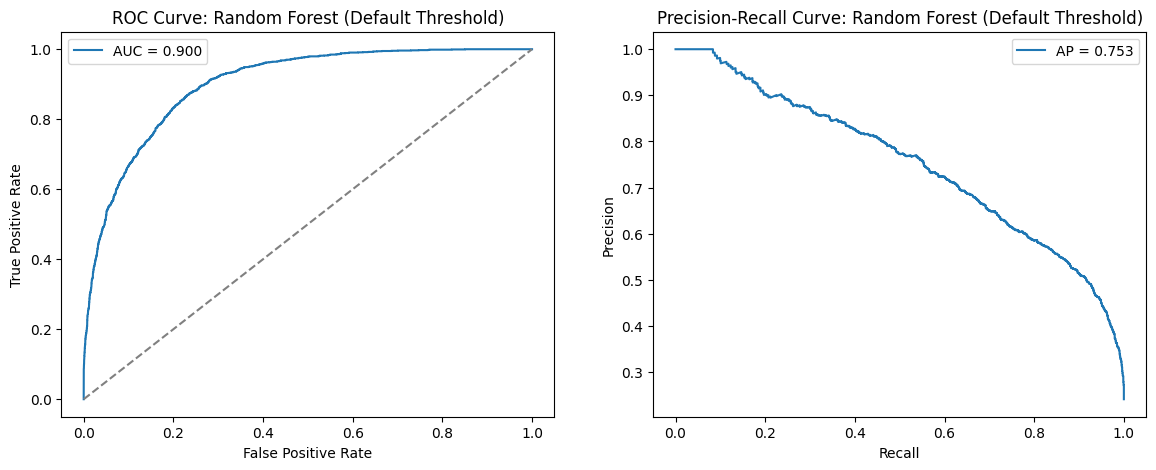

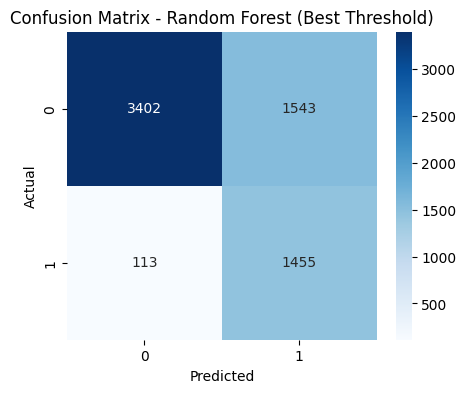

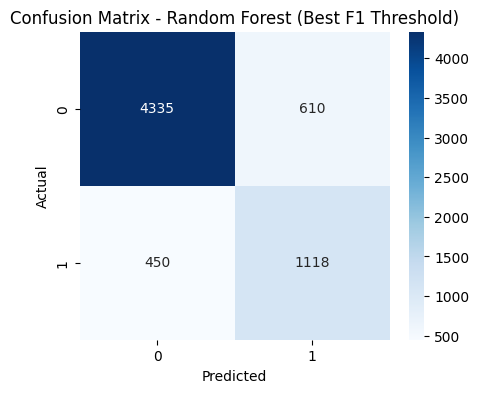

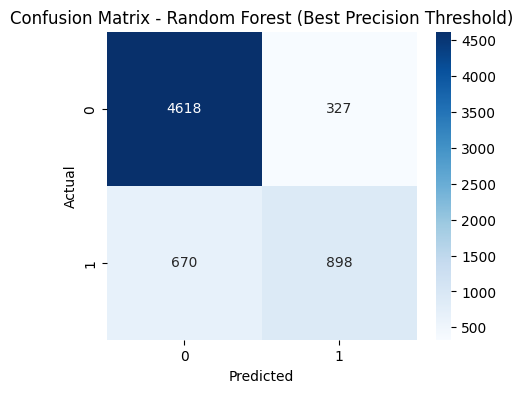

In [41]:
# Logistic Regression plots (numeric features only)
plot_confusion_matrix(y_bin_test, y_pred_lr, "Logistic Regression (Default Threshold)")
plot_roc_pr_curves(grid_lr.best_estimator_, X_test, y_bin_test, "Logistic Regression (Default Threshold)")
plot_confusion_matrix(y_bin_test, y_pred_lr_best, "Logistic Regression (Best Threshold)")
plot_confusion_matrix(y_bin_test, y_pred_lr_best_f1, "Logistic Regression (Best F1 Threshold)")
plot_confusion_matrix(y_bin_test, y_pred_lr_best_prec, "Logistic Regression (Best Precision Threshold)")

# Random Forest plots
plot_confusion_matrix(y_bin_test, y_pred_rf, "Random Forest (Default Threshold)")
plot_roc_pr_curves(grid_rf.best_estimator_, X_test, y_bin_test, "Random Forest (Default Threshold)")
plot_confusion_matrix(y_bin_test, y_pred_rf_best, "Random Forest (Best Threshold)")
plot_confusion_matrix(y_bin_test, y_pred_rf_best_f1, "Random Forest (Best F1 Threshold)")
plot_confusion_matrix(y_bin_test, y_pred_rf_best_prec, "Random Forest (Best Precision Threshold)")

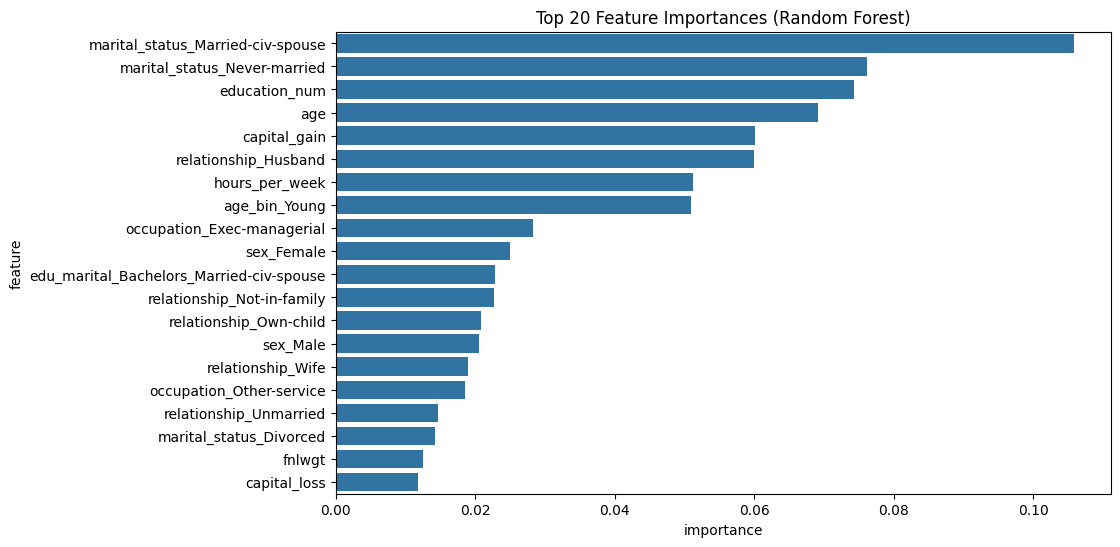

In [42]:
if hasattr(grid_rf.best_estimator_['clf'], 'feature_importances_'):
    importances = grid_rf.best_estimator_['clf'].feature_importances_
    feature_names_num = numeric_features
    feature_names_cat = grid_rf.best_estimator_['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names = np.concatenate([feature_names_num, feature_names_cat])

    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x='importance', y='feature', data=fi_df.head(20))
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.show()

In [43]:
import joblib

# Save best Random Forest model
joblib.dump(grid_rf.best_estimator_, 'best_random_forest.joblib')

# Save best Logistic Regression model (numeric features only)
joblib.dump(grid_lr.best_estimator_, 'best_logistic_regression.joblib')

print('Models saved successfully.')

Models saved successfully.


In [44]:
print(df.columns)



Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income', 'age_bin', 'edu_marital', 'region'],
      dtype='object')


In [45]:
df_full = pd.read_csv("adult.csv")
print(df['income'].value_counts(normalize=True) * 100)

income
<=50K    75.919044
>50K     24.080956
Name: proportion, dtype: float64


In [46]:
import pandas as pd
df = pd.read_csv("adult.csv")
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?

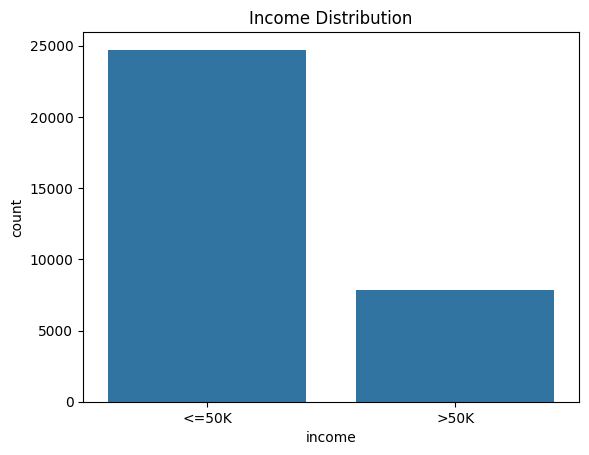

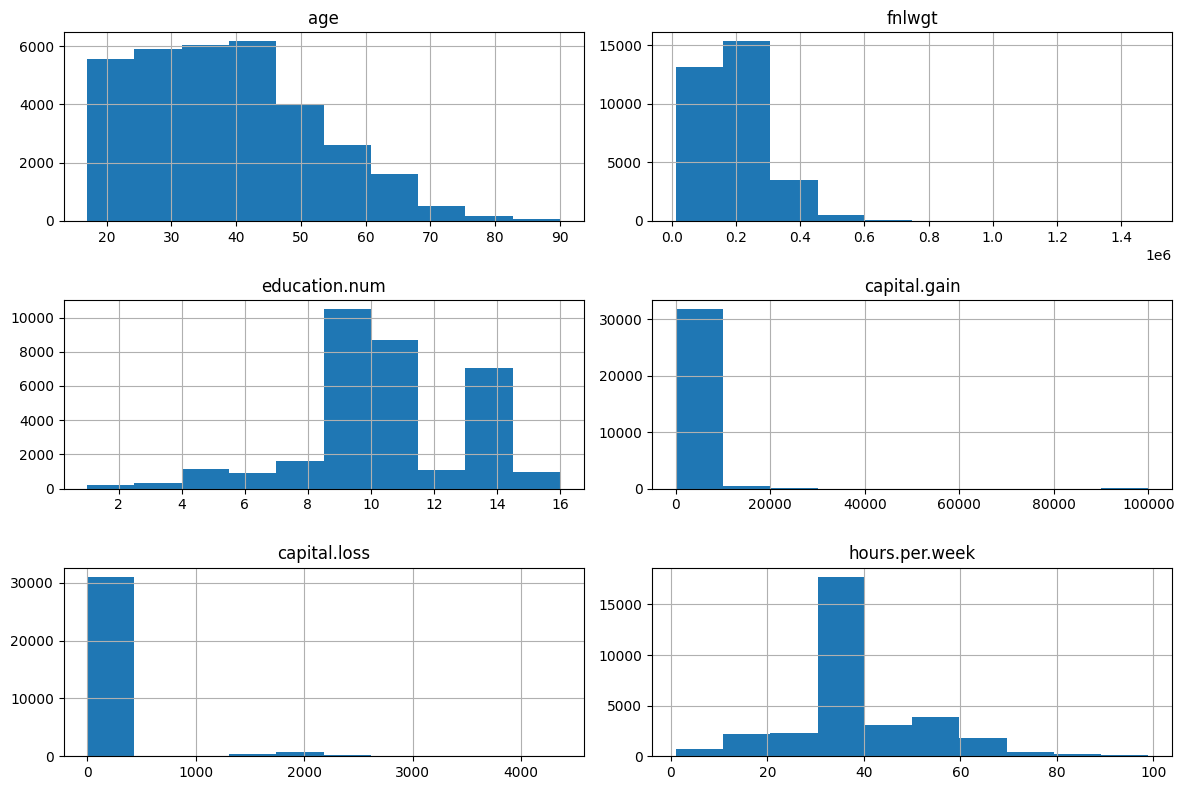

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='income', data=df)
plt.title('Income Distribution')
plt.show()

df.select_dtypes(include=np.number).hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

Columns in X_test (before any processing in this cell):
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'age_bin', 'edu_marital', 'region']

Columns expected by the fitted ColumnTransformer (from grid_lr):
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'age_bin', 'edu_marital', 'region']

--- Confusion Matrices (Test Set) ---
Best F1 thresholds variables not found (best_thresh_lr_best_f1 or best_thresh_rf_best_f1). Using default grid search predictions.


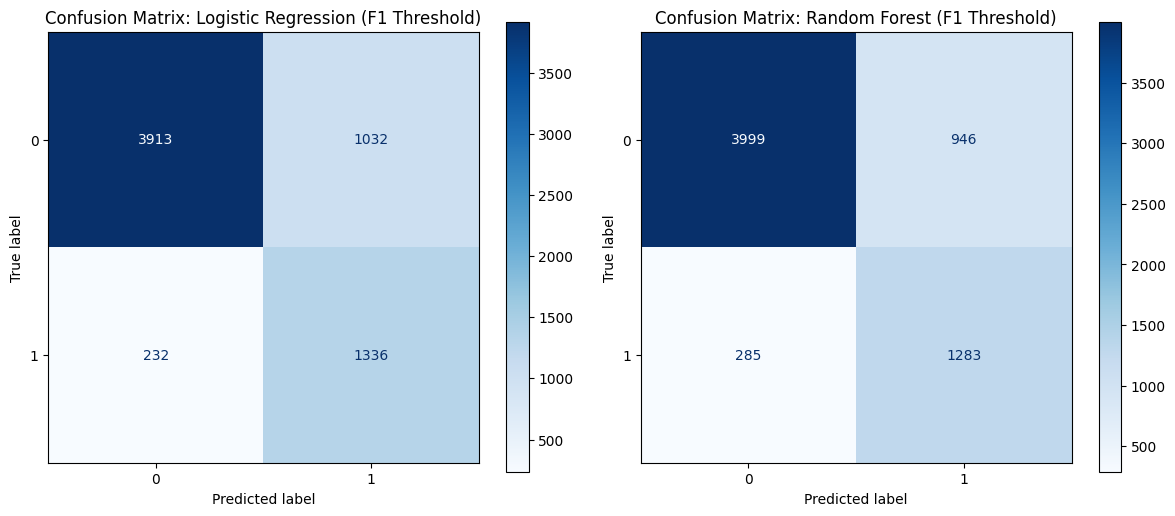


--- ROC Curves (Test Set) ---


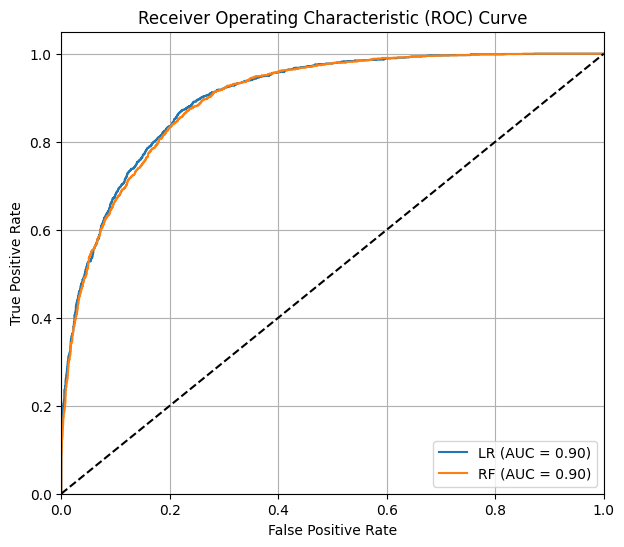


--- Precision-Recall Curves (Test Set) ---


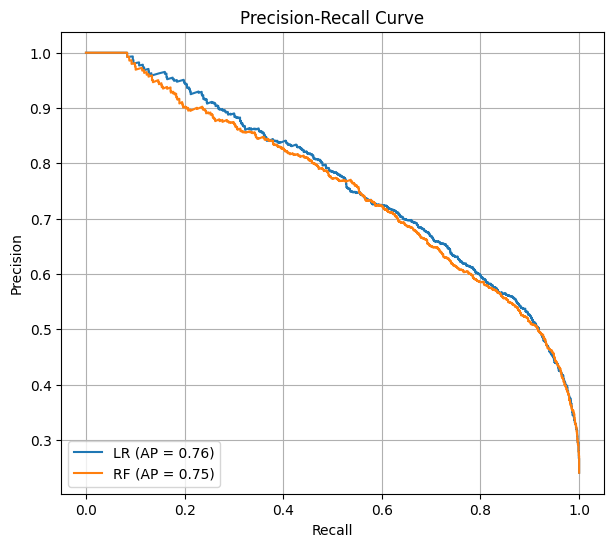


--- Minority Class Metrics (Train vs. Test) ---


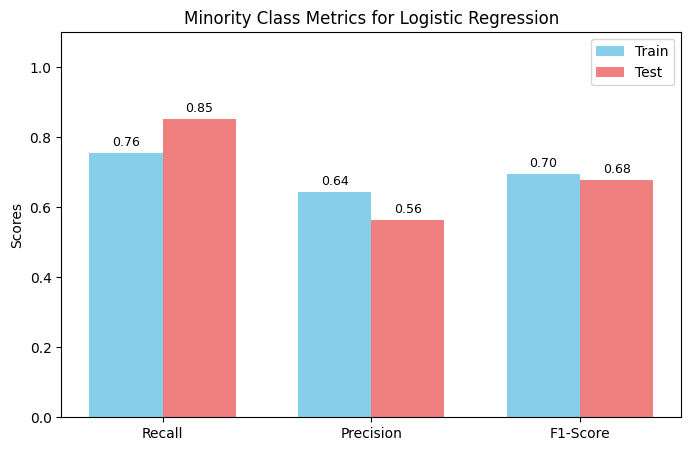

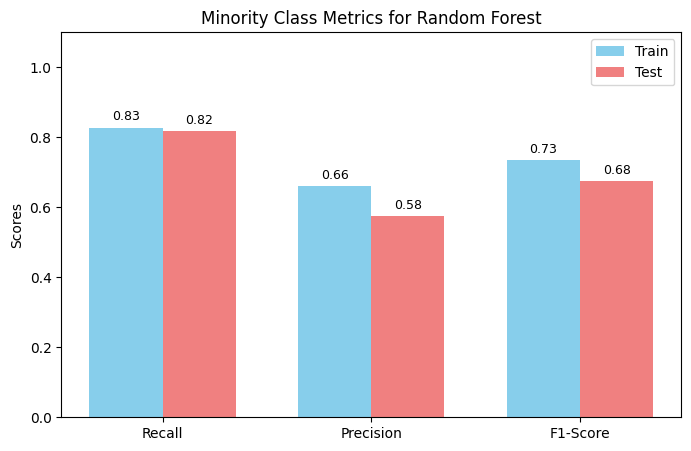


--- Feature Importance (Random Forest) ---


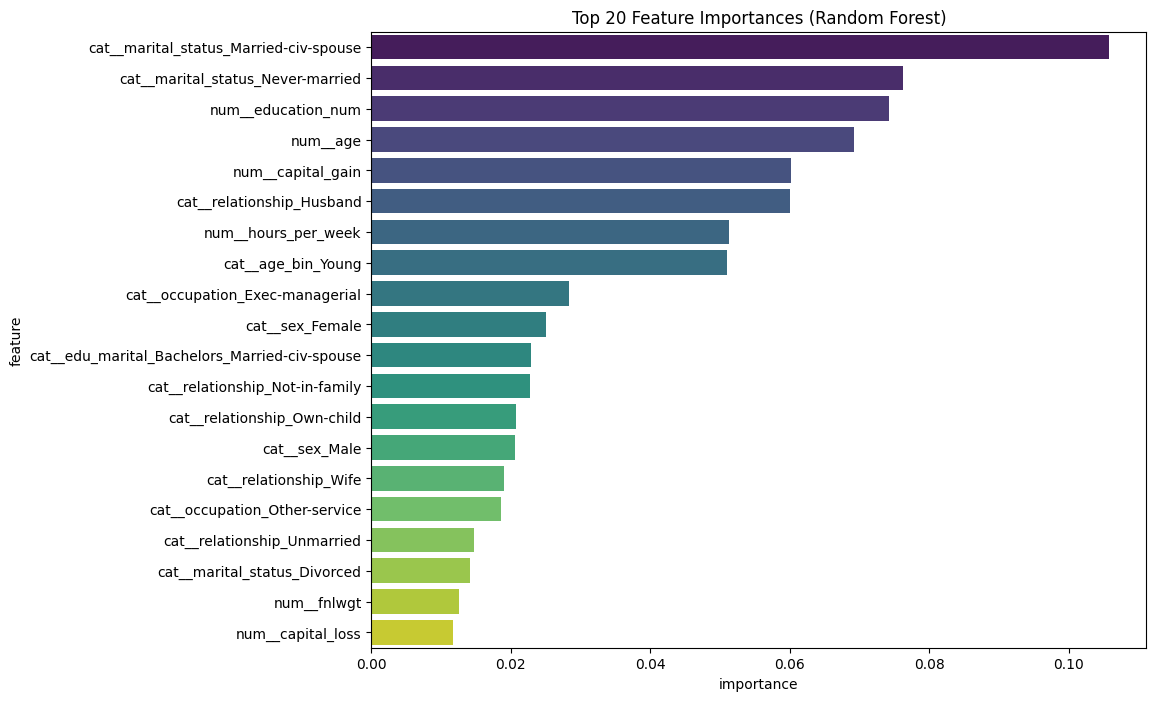


--- Distribution of Key Categorical Features by Income ---


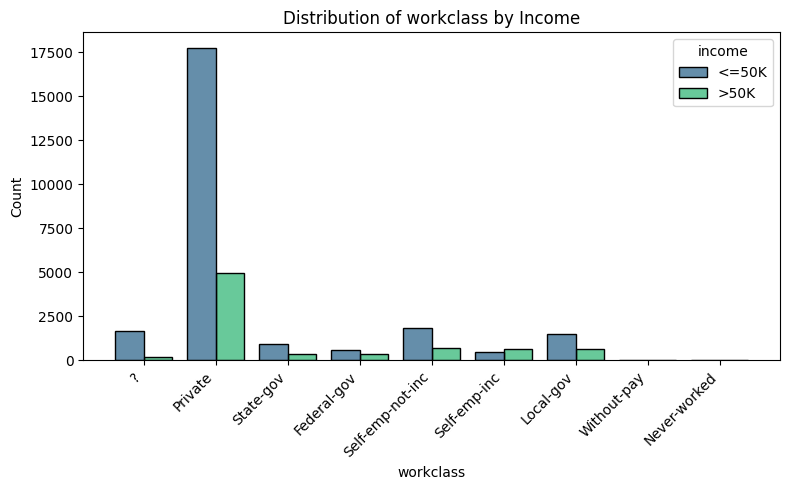

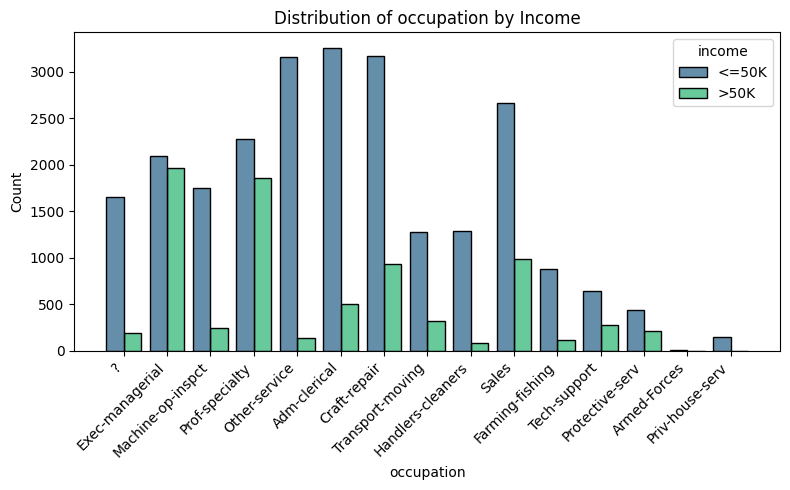

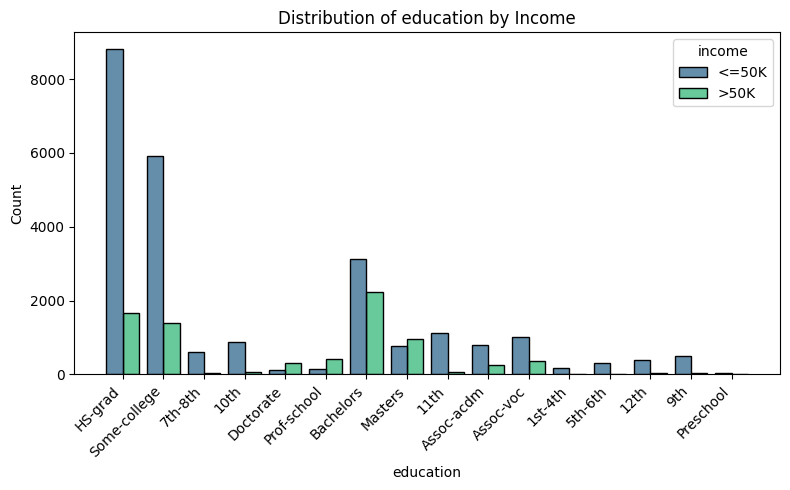

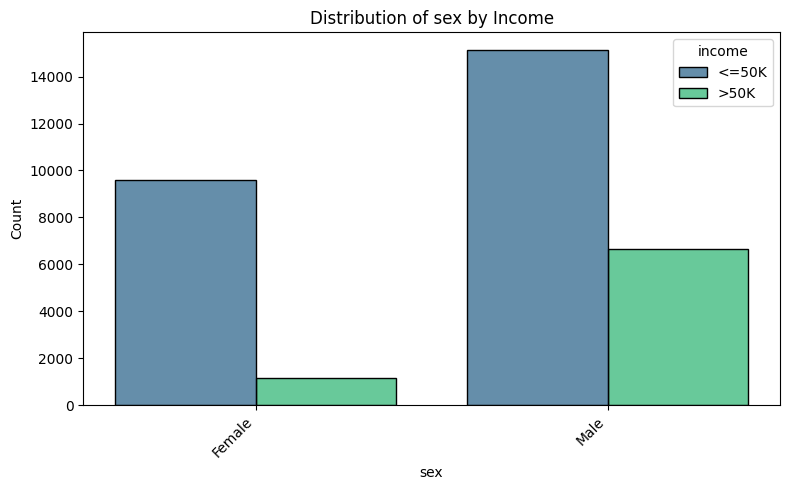


--- Classification Reports (Test Set, Best F1 Threshold) ---

Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      4945
           1       0.56      0.85      0.68      1568

    accuracy                           0.81      6513
   macro avg       0.75      0.82      0.77      6513
weighted avg       0.85      0.81      0.82      6513


Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      4945
           1       0.58      0.82      0.68      1568

    accuracy                           0.81      6513
   macro avg       0.75      0.81      0.77      6513
weighted avg       0.85      0.81      0.82      6513



In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import pandas as pd # Assuming pandas is needed for feature importance plotting

# Assuming grid_rf and grid_lr are your fitted GridSearchCV objects
# Assuming X_test, y_bin_test are your test data and binary target

# --- IMPORTANT CHECK AND REMOVAL OF REDUNDANT FEATURE ENGINEERING ---
# X_test should already contain the engineered features from the previous cells
# (age_bin, edu_marital, region) because you applied them to df *before* splitting.
# The feature engineering steps below were redundant and potentially problematic
# if they were re-applying transformations or causing column order/name issues.
# Let's remove the explicit feature engineering on X_test_processed here.

# Instead of creating X_test_processed and re-engineering,
# we should use the existing X_test which already has the engineered features.
# If the original X_test was somehow overwritten or incorrect,
# the issue lies before this cell. Assuming X_test is correct as produced
# by the train_test_split after feature engineering on df:
X_test_processed = X_test.copy() # A copy is still good practice

# --- Debugging: Check columns ---
print("Columns in X_test (before any processing in this cell):")
print(X_test.columns.tolist())

# Get the columns the preprocessor was fitted on
# The preprocessor is inside the best_estimator_ pipeline
fitted_preprocessor = grid_lr.best_estimator_.named_steps['preprocessor'] # Or grid_rf
expected_columns_lr = fitted_preprocessor.feature_names_in_ # This shows columns expected by the preprocessor

print("\nColumns expected by the fitted ColumnTransformer (from grid_lr):")
print(expected_columns_lr.tolist())

# Compare the sets of columns
missing_in_xtest = set(expected_columns_lr) - set(X_test.columns)
extra_in_xtest = set(X_test.columns) - set(expected_columns_lr)

if missing_in_xtest:
    print(f"\nERROR: X_test is missing columns expected by the preprocessor: {missing_in_xtest}")
    # This is likely the root cause based on your traceback.
    # The issue is likely in a cell *before* this one where X_test was created.
elif extra_in_xtest:
     print(f"\nWARNING: X_test contains extra columns not expected by the preprocessor: {extra_in_xtest}")
     # The preprocessor will ignore these if remainder='passthrough' or 'drop'
     # but it's good to be aware. The error was about *missing* columns, though.

# --- Continue with plotting using the correct X_test (which has engineered features) ---

# --- 1. Confusion Matrices (using the plot_conf_matrix function) ---
print("\n--- Confusion Matrices (Test Set) ---")

def plot_conf_matrix(y_true, y_pred, title, ax):
    """Plots a confusion matrix on a given axes."""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix: {title}')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Calculate probabilities using the correct X_test
# Note: The fitted pipeline (grid_lr.best_estimator_) handles the preprocessing internally
y_probs_lr_processed = grid_lr.best_estimator_.predict_proba(X_test)[:, 1]
y_probs_rf_processed = grid_rf.best_estimator_.predict_proba(X_test)[:, 1]

# Re-apply best thresholds found earlier (assuming best_thresh_lr/rf_best_f1 are defined)
# If you want to use the best recall thresholds, replace _best_f1 with _best
try:
    # Ensure best_thresh_lr_best_f1 and best_thresh_rf_best_f1 are defined from a previous cell
    y_pred_test_lr_best_f1_processed = (y_probs_lr_processed >= best_thresh_lr_best_f1).astype(int)
    y_pred_test_rf_best_f1_processed = (y_probs_rf_processed >= best_thresh_rf_best_f1).astype(int)
    print("Using predictions based on best F1 validation thresholds (applied to test set).")
except NameError:
    print("Best F1 thresholds variables not found (best_thresh_lr_best_f1 or best_thresh_rf_best_f1). Using default grid search predictions.")
    y_pred_test_lr_best_f1_processed = grid_lr.best_estimator_.predict(X_test)
    y_pred_test_rf_best_f1_processed = grid_rf.best_estimator_.predict(X_test)


plot_conf_matrix(y_bin_test, y_pred_test_lr_best_f1_processed, 'Logistic Regression (F1 Threshold)', ax=axes[0])
plot_conf_matrix(y_bin_test, y_pred_test_rf_best_f1_processed, 'Random Forest (F1 Threshold)', ax=axes[1])
plt.tight_layout()
plt.show()


# --- 2. ROC Curves ---
print("\n--- ROC Curves (Test Set) ---")
plt.figure(figsize=(7, 6))

# Logistic Regression
# Use probabilities from the correctly processed X_test
fpr_lr, tpr_lr, _ = roc_curve(y_bin_test, y_probs_lr_processed)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC = {roc_auc_lr:.2f})')

# Random Forest
# Use probabilities from the correctly processed X_test
fpr_rf, tpr_rf, _ = roc_curve(y_bin_test, y_probs_rf_processed)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], 'k--') # Diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- 3. Precision-Recall Curves ---
print("\n--- Precision-Recall Curves (Test Set) ---")
plt.figure(figsize=(7, 6))

# Logistic Regression
# Use probabilities from the correctly processed X_test
precision_lr, recall_lr, _ = precision_recall_curve(y_bin_test, y_probs_lr_processed)
ap_lr = average_precision_score(y_bin_test, y_probs_lr_processed)
plt.plot(recall_lr, precision_lr, label=f'LR (AP = {ap_lr:.2f})')

# Random Forest
# Use probabilities from the correctly processed X_test
precision_rf, recall_rf, _ = precision_recall_curve(y_bin_test, y_probs_rf_processed)
ap_rf = average_precision_score(y_bin_test, y_probs_rf_processed)
plt.plot(recall_rf, precision_rf, label=f'RF (AP = {ap_rf:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


# --- 4. Metric Comparison Bar Charts (Minority Class: Label 1) ---
print("\n--- Minority Class Metrics (Train vs. Test) ---")

# Need to ensure minority_class_metrics function is defined if it's not global
def minority_class_metrics(y_true, y_pred, minority_class=1):
    recall = recall_score(y_true, y_pred, pos_label=minority_class)
    precision = precision_score(y_true, y_pred, pos_label=minority_class)
    f1 = f1_score(y_true, y_pred, pos_label=minority_class)
    return recall, precision, f1

# Use the predictions based on the processed test set for calculating test metrics
# Assuming y_pred_train_lr and y_pred_train_rf from the training cell are correct
# These should have been calculated on X_train which includes engineered features.
# If not, you might need to recalculate them using grid_lr.predict(X_train) etc.
train_recall_lr, train_precision_lr, train_f1_lr = minority_class_metrics(y_bin_train, y_pred_train_lr)
train_recall_rf, train_precision_rf, train_f1_rf = minority_class_metrics(y_bin_train, y_pred_train_rf)


# Use the *processed* test set predictions for test metrics
test_recall_lr, test_precision_lr, test_f1_lr = minority_class_metrics(y_bin_test, y_pred_test_lr_best_f1_processed)
test_recall_rf, test_precision_rf, test_f1_rf = minority_class_metrics(y_bin_test, y_pred_test_rf_best_f1_processed)


train_metrics_lr = [train_recall_lr, train_precision_lr, train_f1_lr]
test_metrics_lr = [test_recall_lr, test_precision_lr, test_f1_lr]

train_metrics_rf = [train_recall_rf, train_precision_rf, train_f1_rf]
test_metrics_rf = [test_recall_rf, test_precision_rf, test_f1_rf]

# Use the plot_metrics function you defined
def plot_metrics(train_metrics, test_metrics, model_name):
    labels = ['Recall', 'Precision', 'F1-Score']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5)) # Adjust figure size
    rects1 = ax.bar(x - width/2, train_metrics, width, label='Train', color='skyblue')
    rects2 = ax.bar(x + width/2, test_metrics, width, label='Test', color='lightcoral')

    ax.set_ylabel('Scores')
    ax.set_title(f'Minority Class Metrics for {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0,1.1) # Extend y-limit slightly for labels
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects1)
    autolabel(rects2)

    plt.show()

plot_metrics(train_metrics_lr, test_metrics_lr, "Logistic Regression")
plot_metrics(train_metrics_rf, test_metrics_rf, "Random Forest")


# --- 5. Feature Importance (Random Forest) ---
print("\n--- Feature Importance (Random Forest) ---")
# This code block already exists and is good

if hasattr(grid_rf.best_estimator_['clf'], 'feature_importances_'):
    importances = grid_rf.best_estimator_['clf'].feature_importances_
    # Need the feature names *after* preprocessing for importance plot
    # Get feature names from the fitted preprocessor
    preprocessor_fitted = grid_rf.best_estimator_['preprocessor']
    # Ensure get_feature_names_out is called correctly on the fitted preprocessor
    # This will include original numeric columns and one-hot encoded categorical columns
    feature_names_transformed = preprocessor_fitted.get_feature_names_out()


    fi_df = pd.DataFrame({'feature': feature_names_transformed, 'importance': importances}).sort_values(by='importance', ascending=False)
    plt.figure(figsize=(10,8)) # Increase figure size for more features
    sns.barplot(x='importance', y='feature', data=fi_df.head(20), palette='viridis') # Show top 20
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.show()
else:
    print("Random Forest classifier does not have feature_importances_ attribute.")


# --- 6. Distribution Plots for Key Categorical Features by Target Class ---
print("\n--- Distribution of Key Categorical Features by Income ---")

# Select a few important categorical features to visualize
key_categorical_cols = ['workclass', 'marital_status', 'occupation', 'education', 'sex', 'age_bin', 'region']

for col in key_categorical_cols:
    # Use the original df for these plots as it contains the original data distributions
    if col in df.columns: # Use the df from the beginning of the notebook for visualization
        plt.figure(figsize=(8, 5))
        # Use 'count' to show raw counts or 'density' to show proportions
        sns.histplot(data=df, x=col, hue='income', multiple='dodge', shrink=.8, palette='viridis')
        plt.title(f'Distribution of {col} by Income')
        plt.xticks(rotation=45, ha='right') # Rotate labels for readability
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: Column '{col}' not found in DataFrame 'df'. Skipping visualization.")

# --- Display Classification Reports ---
print("\n--- Classification Reports (Test Set, Best F1 Threshold) ---")
# Use the predictions based on the processed test set for the classification report
# Assuming y_pred_test_lr_best_f1_processed and y_pred_test_rf_best_f1_processed are defined above

print("\nLogistic Regression:")
print(classification_report(y_bin_test, y_pred_test_lr_best_f1_processed))

print("\nRandom Forest:")
print(classification_report(y_bin_test, y_pred_test_rf_best_f1_processed))

In [49]:
import shap
import numpy as np
import pandas as pd

# Extract fitted preprocessor and classifier from the pipeline
preprocessor_rf = grid_rf.best_estimator_.named_steps['preprocessor']
model_rf = grid_rf.best_estimator_.named_steps['clf']

# Transform X_test using the preprocessor
X_test_transformed_rf = preprocessor_rf.transform(X_test)
feature_names_rf = preprocessor_rf.get_feature_names_out()

# Create DataFrame from transformed data
X_test_df_rf = pd.DataFrame(X_test_transformed_rf, columns=feature_names_rf)

# Sample 100 rows for faster SHAP computation
X_sample_rf = X_test_df_rf.sample(n=100, random_state=42)

# Create SHAP TreeExplainer
explainer_rf = shap.TreeExplainer(model_rf)

# Compute SHAP values for sampled data
shap_values_rf = explainer_rf.shap_values(X_sample_rf)

# Check the correct SHAP value array
print("SHAP shape:", np.array(shap_values_rf[1]).shape)  # should be (100, 104)
print("Data shape:", X_sample_rf.shape)                  # should be (100, 104)

# ✅ Summary plot for class 1 (>50K)
shap.summary_plot(shap_values_rf[1], X_sample_rf, show=True)


SHAP shape: (209, 2)
Data shape: (100, 209)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [137]:
# Compute SHAP values (for TreeExplainer this returns a list with 2 arrays for binary classification)
shap_values_rf = explainer_rf.shap_values(X_sample_rf)

# Print type and shape
print("Type of shap_values_rf:", type(shap_values_rf))
print("Length of shap_values_rf:", len(shap_values_rf))
print("Shape of shap_values_rf[0]:", np.array(shap_values_rf[0]).shape)
print("Shape of shap_values_rf[1]:", np.array(shap_values_rf[1]).shape)
print("Shape of X_sample_rf:", X_sample_rf.shape)


Type of shap_values_rf: <class 'numpy.ndarray'>
Length of shap_values_rf: 100
Shape of shap_values_rf[0]: (104, 2)
Shape of shap_values_rf[1]: (104, 2)
Shape of X_sample_rf: (100, 104)


In [50]:
# Sample 100 raw test instances
X_sample_raw = X_test.sample(n=100, random_state=42)


In [51]:
# Extract preprocessor and classifier from pipeline
preprocessor = pipeline.named_steps['preprocessor']
model = pipeline.named_steps['clf']

# Transform the sample for SHAP
X_sample_transformed = preprocessor.transform(X_sample_raw)

# If sparse matrix, convert to dense
if hasattr(X_sample_transformed, "toarray"):
    X_sample_transformed = X_sample_transformed.toarray()


NameError: name 'pipeline' is not defined

In [140]:
import shap

# Create explainer
explainer_rf = shap.TreeExplainer(model)

# Compute SHAP values
shap_values_rf = explainer_rf.shap_values(X_sample_transformed)

# Optional: get feature names
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame for easier debugging (optional)
import pandas as pd
X_sample_df = pd.DataFrame(X_sample_transformed, columns=feature_names)


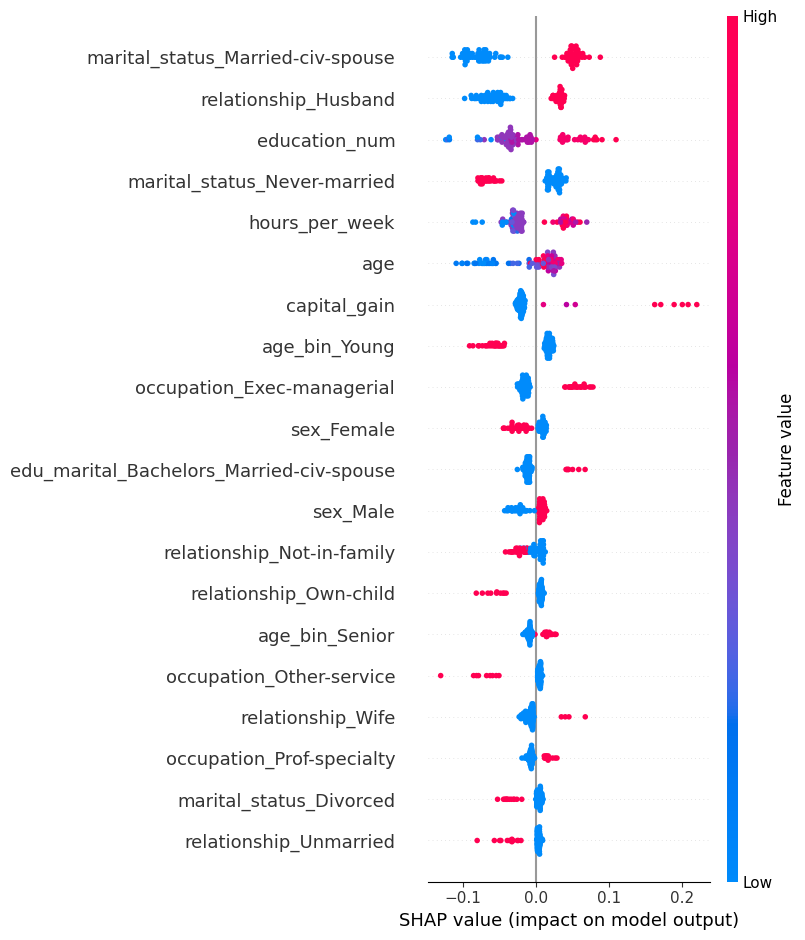

In [75]:
import shap
import pandas as pd
import numpy as np # Import numpy

# 1. Extract the pipeline steps

pipeline = grid_rf.best_estimator_ # Use the best performing pipeline from GridSearchCV

preprocessor = pipeline.named_steps['preprocessor']  # exact name from your pipeline
model = pipeline.named_steps['clf']

# 2. Select a sample of data to explain (for speed, use 100 rows or less)
# Ensure X_test is the DataFrame containing original+engineered features before preprocessing
X_sample = X_test.sample(n=100, random_state=42)

# 3. Preprocess the sample using the pipeline's preprocessor
X_sample_transformed = preprocessor.transform(X_sample)

# If the transformed output is sparse, convert to a dense numpy array
if hasattr(X_sample_transformed, "toarray"):
    X_sample_transformed = X_sample_transformed.toarray()

# 4. Get feature names from preprocessor (for numeric and categorical columns)
# This function extracts the names after one-hot encoding.
def get_transformed_feature_names(preprocessor):
    """Helper function to get feature names from a ColumnTransformer."""
    output_features = []
    for name, transformer, features in preprocessor.transformers_:
        if name == 'remainder':
            # If remainder is 'passthrough', add original column names
            if transformer == 'passthrough':
                # Remainder features are the ones not in any explicit transformer list
                # Get the full list of input features
                input_features = preprocessor.feature_names_in_
                # Find which ones were *not* handled by explicit transformers
                handled_features = []
                for _, trans, feats in preprocessor.transformers_:
                    if trans != 'passthrough' and hasattr(trans, 'get_feature_names_out'):
                         handled_features.extend(feats) # Use original feature names here
                    elif trans != 'passthrough':
                        handled_features.extend(feats) # Assume original names if no get_feature_names_out
                remainder_features = [f for f in input_features if f not in handled_features]
                output_features.extend(remainder_features)

        elif hasattr(transformer, 'get_feature_names_out'):
            # Get feature names for transformers that support it (like OHE)
            # Need to handle potential list of feature names passed to transformer
            if isinstance(features, str): # If only one feature name was passed as string
                 output_features.extend(transformer.get_feature_names_out([features]))
            else: # Assume list of feature names
                output_features.extend(transformer.get_feature_names_out(features))
        else:
            # For transformers like StandardScaler, assume names are same as input features
            output_features.extend(features)
    return output_features


feature_names_transformed = get_transformed_feature_names(preprocessor)

# 5. Convert transformed data to DataFrame with feature names for SHAP plotting
X_sample_df_transformed = pd.DataFrame(X_sample_transformed, columns=feature_names_transformed)


# 6. Create SHAP TreeExplainer for the fitted Random Forest model
# The explainer needs the trained model directly
explainer_rf = shap.TreeExplainer(model)

# 7. Calculate SHAP values for the sample
# This returns a list of arrays for binary classification
# Based on your global variables, this appears to return shape (n_samples, n_features, n_classes)
shap_values_rf_list = explainer_rf.shap_values(X_sample_transformed)

# Check the shape and type of the list elements (optional, for debugging)
# print("Shape of SHAP values raw output:", np.array(shap_values_rf_list).shape)
# print("Shape of data used for SHAP:", X_sample_df_transformed.shape)


# 8. Select SHAP values for the target class (class 1, income >50K)
# This selects all samples and all features for the second dimension (class index 1)
shap_values_for_plot = shap_values_rf_list[:, :, 1]


# 9. Ensure the shape matches the data DataFrame before plotting
# The assertion should now pass
assert shap_values_for_plot.shape == X_sample_df_transformed.shape, \
    f"Shape mismatch: SHAP values {shap_values_for_plot.shape}, Data {X_sample_df_transformed.shape}"


# 10. Plot summary plot for class 1 (>50K income)
# Pass the SHAP values array and the corresponding DataFrame
shap.summary_plot(shap_values_for_plot, X_sample_df_transformed, show=True)

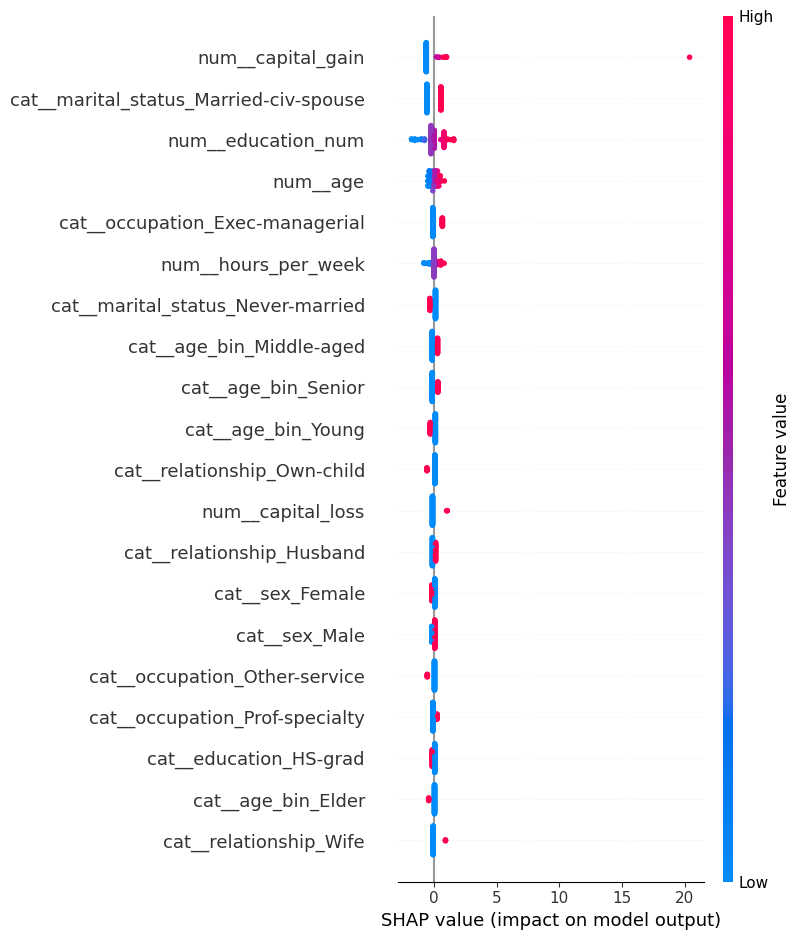

In [61]:
import shap
import pandas as pd

# Extract the pipeline with best params
best_pipe_lr = grid_lr.best_estimator_

# Extract the preprocessor and classifier from pipeline
preprocessor = best_pipe_lr.named_steps['preprocessor']
log_reg = best_pipe_lr.named_steps['clf']

# Prepare the training data for SHAP background (processed features)
X_train_processed = preprocessor.transform(X_train)

# Take a sample of test data and preprocess it
X_sample = X_test.sample(100, random_state=42)
X_sample_processed = preprocessor.transform(X_sample)

# Convert to DataFrame with feature names
feature_names = preprocessor.get_feature_names_out()
X_sample_df = pd.DataFrame(X_sample_processed, columns=feature_names)

# Create SHAP LinearExplainer (use "interventional" for model-agnostic explanation)
explainer = shap.LinearExplainer(log_reg, X_train_processed, feature_perturbation="interventional")

# Calculate SHAP values for the sample
shap_values = explainer.shap_values(X_sample_processed)

# Plot SHAP summary
shap.summary_plot(shap_values, X_sample_df, show=True)


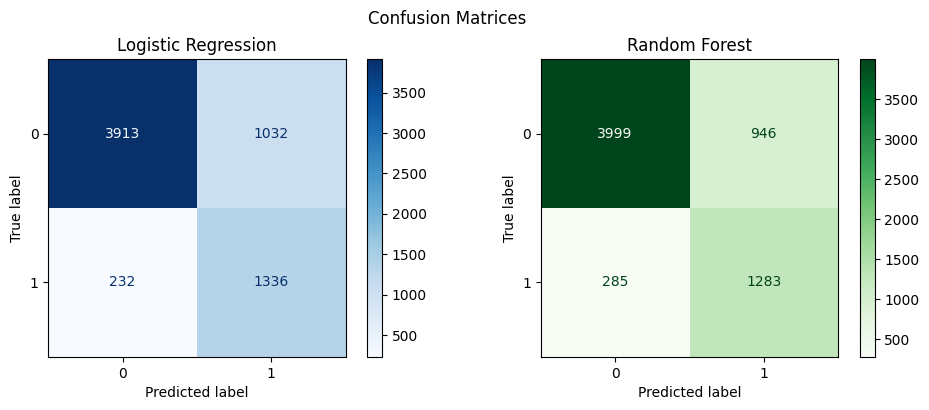

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Logistic Regression Confusion Matrix
ConfusionMatrixDisplay.from_estimator(grid_lr, X_test, y_bin_test, ax=axs[0], cmap='Blues')
axs[0].set_title('Logistic Regression')

# Random Forest Confusion Matrix
ConfusionMatrixDisplay.from_estimator(grid_rf, X_test, y_bin_test, ax=axs[1], cmap='Greens')
axs[1].set_title('Random Forest')

plt.suptitle('Confusion Matrices')
plt.tight_layout()
plt.show()


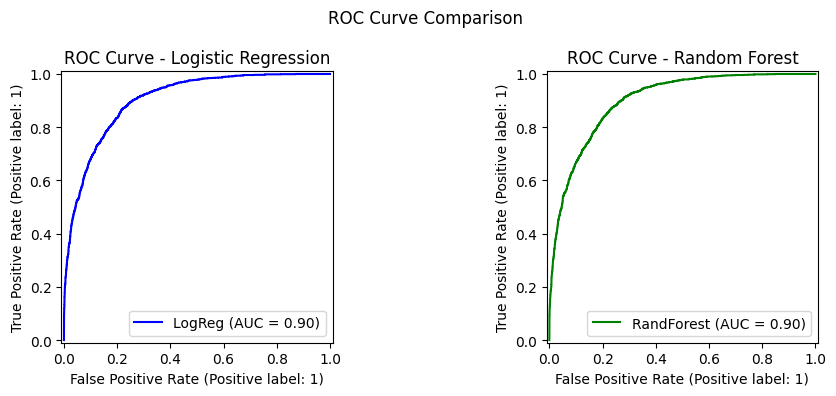

In [79]:
from sklearn.metrics import RocCurveDisplay

y_probs_lr = grid_lr.predict_proba(X_test)[:, 1]
y_probs_rf = grid_rf.predict_proba(X_test)[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# ROC for Logistic Regression
RocCurveDisplay.from_predictions(y_bin_test, y_probs_lr, ax=axs[0], name='LogReg', color='blue')
axs[0].set_title('ROC Curve - Logistic Regression')

# ROC for Random Forest
RocCurveDisplay.from_predictions(y_bin_test, y_probs_rf, ax=axs[1], name='RandForest', color='green')
axs[1].set_title('ROC Curve - Random Forest')

plt.suptitle('ROC Curve Comparison')
plt.tight_layout()
plt.show()


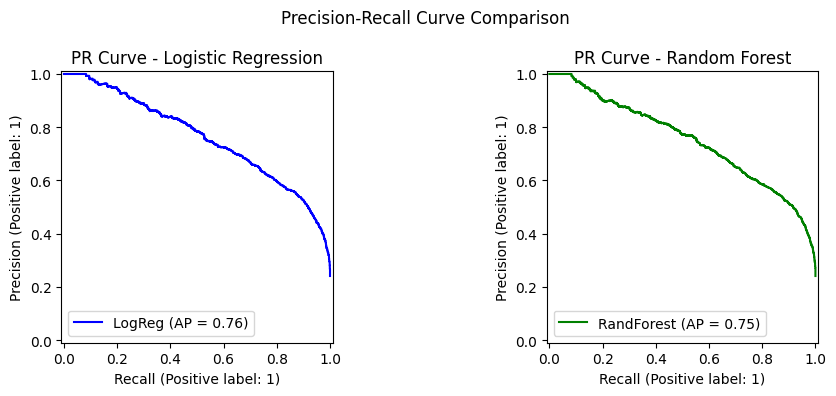

In [80]:
from sklearn.metrics import PrecisionRecallDisplay

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# PR for Logistic Regression
PrecisionRecallDisplay.from_predictions(y_bin_test, y_probs_lr, ax=axs[0], name='LogReg', color='blue')
axs[0].set_title('PR Curve - Logistic Regression')

# PR for Random Forest
PrecisionRecallDisplay.from_predictions(y_bin_test, y_probs_rf, ax=axs[1], name='RandForest', color='green')
axs[1].set_title('PR Curve - Random Forest')

plt.suptitle('Precision-Recall Curve Comparison')
plt.tight_layout()
plt.show()
